In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange 
import xarray as xr
import scipy.io as sio
import datetime as dt
import pyspectral.blackbody

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Download GOES ABI-L1b-RadC band 14 imagery for for Feb 1-15 2020, and create timeseries files for the two Grand Mesa SnowEx 2020 field locations, using the goes-ortho library and command line utilities.

**Download imagery:**

Longwave window (11.2 micron):
* GOES-16 Band 14 (TIR):
  * `python ./download-goes.py -B noaa-goes16 -Y 2020 -M 2 -D 1 15 -p ABI-L1b-RadC -c C14 -b 30 50 -125 -105 -d /storage/GOES`
* GOES-17 Band 14 (TIR):
  * `python ./download-goes.py -B noaa-goes17 -Y 2020 -M 2 -D 1 15 -p ABI-L1b-RadC -c C14 -b 30 50 -125 -105 -d /storage/GOES`
  
Shortwave window (3.9 micron):
* GOES-16 Band 7 (MWIR):
  * `python ./download-goes.py -B noaa-goes16 -Y 2020 -M 2 -D 1 15 -p ABI-L1b-RadC -c C07 -b 30 50 -125 -105 -d /storage/GOES`
* GOES-17 Band 7 (MWIR):
  * `python ./download-goes.py -B noaa-goes17 -Y 2020 -M 2 -D 1 15 -p ABI-L1b-RadC -c C07 -b 30 50 -125 -105 -d /storage/GOES`
  
Visible (red, 0.64 micron):
* GOES-16 Band 2 for a 1x1 degree area (visible, red):
  * `python ./download-goes.py -B noaa-goes16 -Y 2020 -M 2 -D 7 12 -p ABI-L1b-RadC -c C02 -b 39.5 38.5 -108.5 -107.5 -d /storage/GOES`
* GOES-17 Band 2 for a 1x1 degree area (visible, red):
  * `python ./download-goes.py -B noaa-goes17 -Y 2020 -M 2 -D 7 12 -p ABI-L1b-RadC -c C02 -b 39.5 38.5 -108.5 -107.5 -d /storage/GOES`

**Create timeseries files:**
* Grand Mesa West:
  * Create GOES-16 timeseries:
    * Longwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes16/2020/02 -l 39.0339 -108.2140 3033`
      * *GrandMesaWest_GOES-16_timeseries_Feb2020.pkl*
    * Shortwave Window:
      * ...
      * ...
  * Create GOES-17 timeseries:
    * Langwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes17/2020/02 -l 39.0339 -108.2140 3033`
      * ...
    * Shortwave Window:
      * ...
      * ...
* Snow Pit 2S10:
  * Create GOES-16 timeseries:
    * Longwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes16/2020/02 -l 39.0195 -108.1923 3043`
      * *SnowPit2S10_GOES-16_timeseries_Feb2020.pkl*
    * Shortwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes16/2020/2 -c C07 -l 39.0195 -108.1923 3043 -o SnowPit2S10_GOES-16_C07_timeseries_Feb2020.pkl`
      * *SnowPit2S10_GOES-16_C07_timeseries_Feb2020.pkl*
  * Create GOES-17 timeseries:
    * Longwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes17/2020/2 -l 39.0195 -108.1923 3043`
      * *SnowPit2S10_GOES-17_timeseries_Feb2020.pkl*
    * Shortwave Window:
      * `python ./goes-timeseries.py -d /storage/GOES/goes17/2020/2 -c C07 -l 39.0195 -108.1923 3043 -o SnowPit2S10_GOES-17_C07_timeseries_Feb2020.pkl`
      * *SnowPit2S10_GOES-17_C07_timeseries_Feb2020.pkl*

In [3]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    # From: https://stackoverflow.com/questions/34258892/converting-year-and-day-of-year-into-datetime-index-in-pandas
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

Read in the data file:

In [5]:
# Set column headers:
headers_gm1 = ['table', 'year', 'doy', 'time',
               'rad_avg', 'rad_max', 'rad_min', 'rad_std',
               'sb_avg', 'sb_max', 'sb_min', 'sb_std',
               'temp1_avg', 'temp1_max', 'temp1_min', 'temp1_std',
               'temp2_avg', 'temp2_max', 'temp2_min', 'temp2_std',
               'temp3_avg', 'temp3_max', 'temp3_min', 'temp3_std',
               'temp4_avg', 'temp4_max', 'temp4_min', 'temp4_std',
               'temp5_avg', 'temp5_max', 'temp5_min', 'temp5_std',
               'batt','b',]

# Open ground data from GM1 site:
gm1 = pd.read_csv('data/CR10X_GM1_final_storage_1.dat',
                 header = None, names = headers_gm1)

Perform some formatting and cleanup:

In [6]:
# Pad zeros to time strings
gm1['time_str'] = [('0' * (4 - len(str(gm1.time[i])))) + str(gm1.time[i]) for i in range(gm1.shape[0])]

for i in range(gm1.shape[0]):
    if gm1.time_str[i] == '2400':
        gm1.time_str[i] = '0000'
        gm1.doy[i] = gm1.doy[i] + 1
        
# Convert year and day of year to pandas datetime index:
gm1['date'] = compose_date(gm1['year'], days=gm1['doy'])
gm1.index = [pd.to_datetime(str(gm1.date[i])[:-9] + 'T' + str(gm1.time_str[i])) for i in range(gm1.shape[0])]

# Get table 102 entires, battery info
gm1_102 = gm1[gm1.table == 102]

# Remove entries that are part of "Table 102"
gm1 = gm1[gm1.table != 102]

# Remove dates before observation periods (Feb 5th for GM1)
gm1 = gm1[gm1.index >= pd.datetime(2020,2,5,11,0)]

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


Inspect the data series:

In [7]:
gm1.tail()

,table,year,doy,time,rad_avg,rad_max,rad_min,rad_std,sb_avg,sb_max,...,temp4_min,temp4_std,temp5_avg,temp5_max,temp5_min,temp5_std,batt,b,time_str,date
2020-02-12 15:10:00,101,2020,43,1510,-9.3700,-9.0437,-9.7752,0.184,-5.9076,-5.8069,...,-7.3058,0.009,-6.1055,-6.1015,-6.1066,0.002,NaN,NaN,1510,2020-02-12
2020-02-12 15:15:00,101,2020,43,1515,-8.9315,-8.4953,-9.5780,0.336,-6.0095,-5.9826,...,-7.2757,0.013,-6.0973,-6.0916,-6.1065,0.005,NaN,NaN,1515,2020-02-12
2020-02-12 15:20:00,101,2020,43,1520,-10.1200,-9.7869,-10.4040,0.215,-6.4162,-6.0925,...,-7.2557,0.009,-6.1010,-6.0916,-6.1064,0.004,NaN,NaN,1520,2020-02-12
2020-02-12 15:25:00,101,2020,43,1525,-9.5534,-9.2206,-9.9084,0.236,-6.7033,-6.6493,...,-7.2357,0.013,-6.0921,-6.0867,-6.1015,0.005,NaN,NaN,1525,2020-02-12
2020-02-12 15:30:00,101,2020,43,1530,-9.6601,-8.9519,-10.7450,0.551,-6.6635,-6.5886,...,-7.1959,0.005,-6.0883,-6.0868,-6.0918,0.002,NaN,NaN,1530,2020-02-12


Plot:

---

Read in GOES ABI, Band 14 brightness temperature timeseries:

In [23]:
# Read files
g16_c14 = pd.read_pickle('data/GOES_timeseries/SnowPit2S10_GOES-16_timeseries_Feb2020.pkl')
g17_c14 = pd.read_pickle('data/GOES_timeseries/SnowPit2S10_GOES-17_C14_timeseries_Feb2020.pkl')

# Convert UTC to UTC-7 (MST) and set index to the datetime
g16_c14.index  = pd.to_datetime(g16_c14.time) - pd.Timedelta(hours=7)
g17_c14.index  = pd.to_datetime(g17_c14.time) - pd.Timedelta(hours=7)

Read in GOES ABI, Band 14 brightness temperature timeseries:

In [12]:
# Read files
g16_c7 = pd.read_pickle('data/GOES_timeseries/SnowPit2S10_GOES-16_C07_timeseries_Feb2020.pkl')
g17_c7 = pd.read_pickle('data/GOES_timeseries/SnowPit2S10_GOES-17_C07_timeseries_Feb2020.pkl')

# Convert UTC to UTC-7 (MST) and set index to the datetime
g16_c7.index  = pd.to_datetime(g16_c7.time) - pd.Timedelta(hours=7)
g17_c7.index  = pd.to_datetime(g17_c7.time) - pd.Timedelta(hours=7)

---
### Plot all together:

Read all the datetimes we have for aircraft IR

In [13]:
files = [r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED-20200908T002540Z-001\IR_PLANE_PROCESSED\SNOWEX2020_IR_PLANE_2020Feb08_mosaicked.mat',
        r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED-20200908T002540Z-001\IR_PLANE_PROCESSED\SNOWEX2020_IR_PLANE_2020Feb10_mosaicked.mat',
        r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED-20200908T002540Z-001\IR_PLANE_PROCESSED\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked.mat',
        r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED-20200908T002540Z-001\IR_PLANE_PROCESSED\SNOWEX2020_IR_PLANE_2020Feb12_mosaicked.mat'
        ]
datetimes = []
for file in files:
    aircraft_data_mat = sio.loadmat(file)
    for i in range(aircraft_data_mat['time'][0,:].shape[0]):
        matlab_datenum = aircraft_data_mat['time'][0,i]
        python_datetime = pd.datetime.fromtimestamp(matlab_datenum)
        datetimes.append(python_datetime)

datetimes

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  # This is added back by InteractiveShellApp.init_path()


[datetime.datetime(2020, 2, 8, 7, 7, 17, 946189),
 datetime.datetime(2020, 2, 8, 7, 16, 44, 712175),
 datetime.datetime(2020, 2, 8, 7, 28, 32, 337137),
 datetime.datetime(2020, 2, 8, 7, 43, 2, 133228),
 datetime.datetime(2020, 2, 8, 7, 55, 59, 22164),
 datetime.datetime(2020, 2, 8, 8, 7, 54, 639167),
 datetime.datetime(2020, 2, 8, 10, 7, 37, 808115),
 datetime.datetime(2020, 2, 8, 10, 19, 15, 110315),
 datetime.datetime(2020, 2, 8, 10, 29, 16, 175215),
 datetime.datetime(2020, 2, 8, 10, 40, 56, 807211),
 datetime.datetime(2020, 2, 8, 10, 50, 20, 909175),
 datetime.datetime(2020, 2, 8, 11, 1, 9, 260000),
 datetime.datetime(2020, 2, 8, 11, 6, 22, 280167),
 datetime.datetime(2020, 2, 8, 11, 18, 49, 199265),
 datetime.datetime(2020, 2, 8, 11, 31, 35, 765195),
 datetime.datetime(2020, 2, 8, 11, 44, 28, 325184),
 datetime.datetime(2020, 2, 8, 11, 56, 16, 283170),
 datetime.datetime(2020, 2, 10, 14, 52, 32, 360940),
 datetime.datetime(2020, 2, 10, 15, 4, 31, 974179),
 datetime.datetime(2020, 

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_

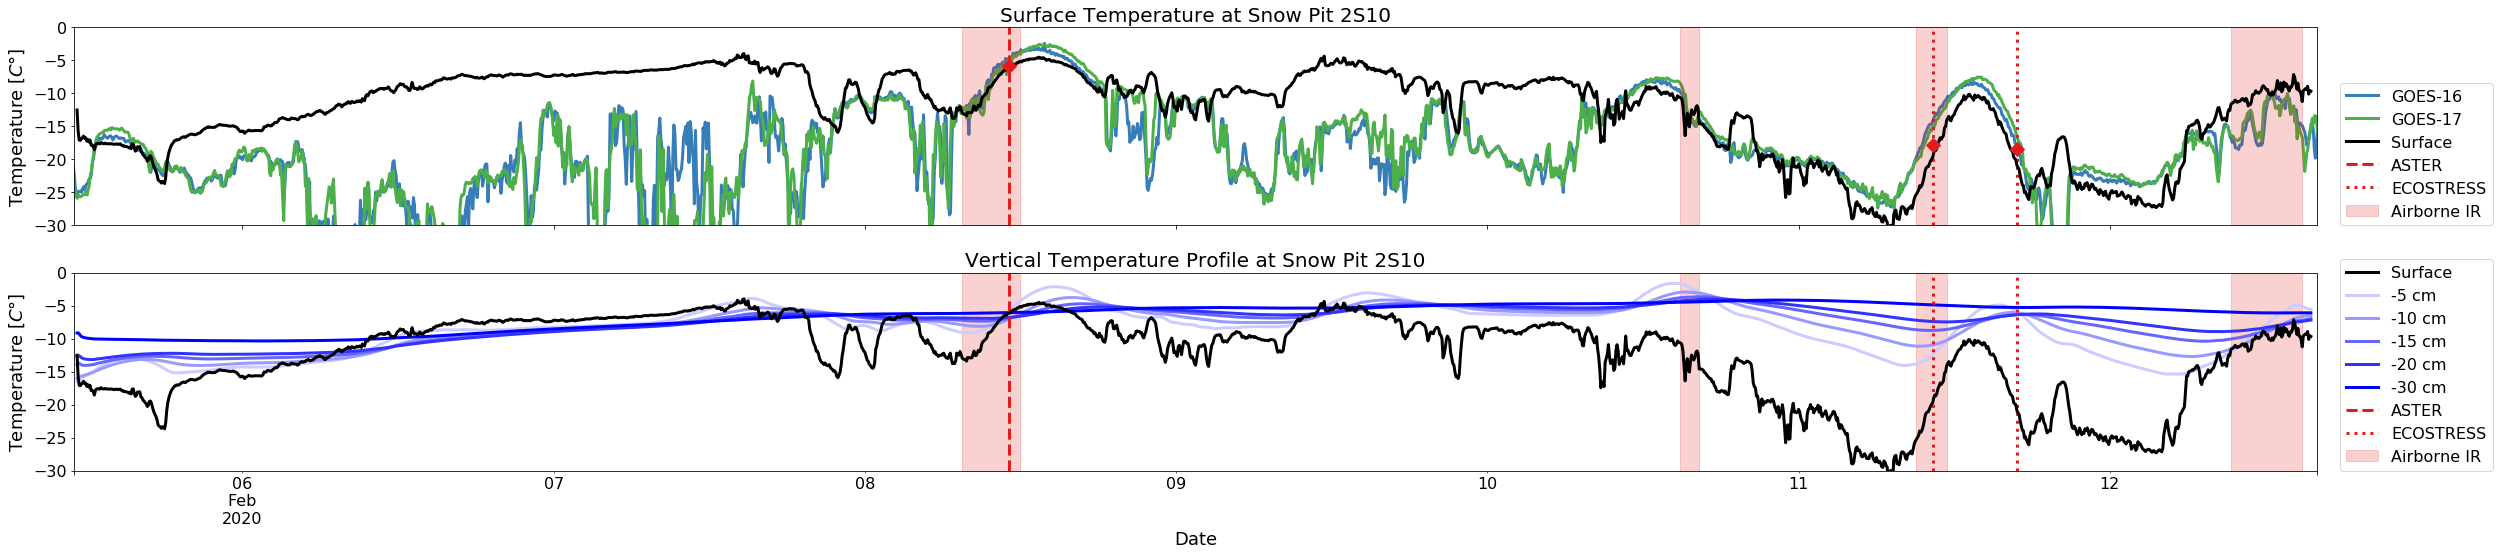

In [14]:
fig, [ax, ax2] = plt.subplots(2,1,figsize=(35,8), tight_layout=True)


startdate = pd.datetime(2020,2,5,11,0)
enddate = pd.datetime(2020,2,12,16,0)

airborne_color = '#e41a1c'
eco_color = '#e41a1c'
ast_color = '#e41a1c'
g16_color = '#377eb8'
g17_color = '#4daf4a'
    

# Plot surface temperature and remotely sensed temps
g16.tb.plot(ax=ax, linestyle='-', linewidth=3, c=g16_color, label='GOES-16', zorder=-0)
g17.tb.plot(ax=ax, linestyle='-', linewidth=3,  c=g17_color, label='GOES-17', zorder=0)
gm1.rad_avg.plot(ax=ax, linestyle='-', linewidth=3,  c='k', label='Surface', zorder=99)
# ASTER Mean Brightness Temp at Snow Pit 2S10 = -5.8 C
ax.plot(pd.datetime(2020,2,8,11,7),-5.8,'D',c=ast_color,markersize=10, zorder=99)
# ECOSTRESS Mean Brightness Temp at Snow Pit 2S10 = -17.9, -18.4 C
ax.plot(pd.datetime(2020,2,11,10,22),-17.9,'D',c=eco_color,markersize=10, zorder=99)
ax.plot(pd.datetime(2020,2,11,16,52),-18.4,'D',c=eco_color,markersize=10, zorder=99)
ax.set_ylim((-30,0))
ax.set_xlim((startdate,enddate))
ax.set_ylabel('Temperature [$C\degree$]')
#ax.set_xlabel('Time')
ax.set_title('Surface Temperature at Snow Pit 2S10');


# Plot vertical snow temperature profile
gm1.rad_avg.plot(ax=ax2, linestyle='-', linewidth=3, c='k', label='Surface', zorder=99)
gm1.temp1_avg.plot(ax=ax2, linestyle='-', linewidth=3, c=[0.8,0.8,1], label='-5 cm')
gm1.temp2_avg.plot(ax=ax2, linestyle='-', linewidth=3, c=[0.6,0.6,1], label='-10 cm')
gm1.temp3_avg.plot(ax=ax2, linestyle='-', linewidth=3, c=[0.4,0.4,1], label='-15 cm')
gm1.temp4_avg.plot(ax=ax2, linestyle='-', linewidth=3, c=[0.2,0.2,1], label='-20 cm')
gm1.temp5_avg.plot(ax=ax2, linestyle='-', linewidth=3, c=[0,0,1], label='-30 cm')

ax2.set_ylim((-30,0))
ax2.set_xlim((startdate,enddate))
ax2.set_ylabel('Temperature [$C\degree$]')
ax2.set_xlabel('Date')
ax2.set_title('Vertical Temperature Profile at Snow Pit 2S10')



# add vertical lines for the aircraft flight datetimes, satellite pass datetimes
for each_ax in [ax, ax2]:
    
    # Airborne IR, Feb 8th
    each_ax.fill_between([pd.datetime(2020, 2, 8, 7, 28), pd.datetime(2020, 2, 8, 11, 56)],
                    [-40, -40],[0, 0], color=airborne_color, alpha=0.2, label='Airborne IR')
    # Airborne IR, Feb 10th
    each_ax.fill_between([pd.datetime(2020, 2, 10, 14, 52), pd.datetime(2020, 2, 10, 16, 18)],
                    [-40, -40],[0, 0], color=airborne_color, alpha=0.2)
    # Airborne IR, Feb 11th
    each_ax.fill_between([pd.datetime(2020, 2, 11, 9, 1), pd.datetime(2020, 2, 11, 11, 26)],
                    [-40, -40],[0, 0], color=airborne_color, alpha=0.2)
    # Airborne IR, Feb 12th
    each_ax.fill_between([pd.datetime(2020, 2, 12, 9, 19), pd.datetime(2020, 2, 12, 14, 47)],
                    [-40, -40],[0, 0], color=airborne_color, alpha=0.2)
    
    # ASTER
    each_ax.axvline(pd.datetime(2020,2,8,11,7), linestyle='--', color=ast_color, linewidth='3', label='ASTER')
    
    # ECOSTRESS
    each_ax.axvline(pd.datetime(2020,2,11,10,22), linestyle=':', color=eco_color, linewidth='3', label='ECOSTRESS')
    each_ax.axvline(pd.datetime(2020,2,11,16,52), linestyle=':', color=eco_color, linewidth='3')

    
# add legends
ax.legend(loc=(1.01,0))
ax2.legend(loc=(1.01,0))
 
fig.autofmt_xdate() 





## GM 1
#times1 = gm1.index
#depths1 = np.array([0, 5, 10, 15, 20, 30])
#temp_data = np.array([gm1.rad_avg, gm1.temp1_avg, gm1.temp2_avg, gm1.temp3_avg, gm1.temp4_avg, gm1.temp5_avg])
#gm1_snow_temp = xr.DataArray(temp_data, coords=[depths1, times1], dims=['depth', 'time'])
#gm1_snow_temp.plot(ax=ax2, cmap='magma', vmin=-30, vmax=0,
#                  cbar_kwargs={'label':'Temperature [$C\degree$]'})
#ax2.set_xlim((startdate,enddate))
#ax2.set_ylim((30,0))
#ax2.set_xlabel('Time')
#ax2.set_ylabel('Depth [cm]')
#ax2.set_title('Vertical Temperature Profile at Snow Pit 2S10')
#
#


#plt.savefig('timeline_.jpg',dpi=300)

---

$\beta(\lambda,T) = \displaystyle\frac{2hc^2}{\lambda^5(e^{\frac{hc}{k \lambda T}}-1)}$

$T = \displaystyle\frac{hc}{k \lambda ln\Big(\frac{2hc^2}{\beta \lambda^5}+1\Big)}$

If we assume that each pixel is a mixture of only forest temperature and snow temperature (also ignoring reflected downwelling longwave), and assuming that snow temperature and forest temperature don't change between each pair of 5-minute timesteps:

$L_i = f_{SCA} \varepsilon_{snow}(\lambda_i,\theta) \beta(\lambda_i,T_{snow}) + 
(1-f_{SCA}) \varepsilon_{forest}(\lambda_i,\theta) \beta(\lambda_i,T_{forest})$

where $i$ is either band 7 or band 14 in this case

We want to solve:

$L_{C07} = f_{SCA} \varepsilon_{snow}(\lambda_{C07},\theta) \beta(\lambda_{C07},T_{snow}) + 
(1-f_{SCA}) \varepsilon_{forest}(\lambda_{C07},\theta) \beta(\lambda_{C07},T_{forest})$

$L_{C14} = f_{SCA} \varepsilon_{snow}(\lambda_{C14},\theta) \beta(\lambda_{C14},T_{snow}) + 
(1-f_{SCA}) \varepsilon_{forest}(\lambda_{C14},\theta) \beta(\lambda_{C14},T_{forest})$

rearranging:

$ \beta(\lambda_{C07},T_{snow}) =  \displaystyle\frac{(1-f_{SCA}) \varepsilon_{forest}(\lambda_{C07},\theta) \beta(\lambda_{C07},T_{forest}) - L_{C07}}{f_{SCA} \varepsilon_{snow}(\lambda_{C07},\theta)}$

$L_{C14} = f_{SCA} \varepsilon_{snow}(\lambda_{C14},\theta) \beta(\lambda_{C14},T_{snow}) + 
(1-f_{SCA}) \varepsilon_{forest}(\lambda_{C14},\theta) \beta(\lambda_{C14},T_{forest})$




In [120]:
def mixed_pixel_spectral_radiance(wavenumber_m, T1, T2, f1=0.5, e1=1.0, e2=1.0):
    '''Radiance of a mixed pixel composed of two surfaces with different temperatures and emissivities.
        Inputs:
                wavenumber_m: wavenumber in m^-1
                T1 and T2: temperature of each surface in K
                f1: fraction of area covered by surface #1 (fraction of area covered by surface #1 = (1-f1))
                e1 and e2: emissivity of each surface
        Output:
                L: spectral radiance in wavenumber space in W m-2 sr-1 (m-1)-1'''
       
    # Calculate blackbody radiation of surface #1
    B1 = pyspectral.blackbody.planck(wavenumber_m, T1 , wavelength=False)
    # Radiance from surface #1
    L1 = f1 * e1 * B1
    
    # Calculate blackbody radiation of surface #2
    B2 = pyspectral.blackbody.planck(wavenumber_m, T2 , wavelength=False)
    # Radiance from surface #2
    L2 = (1-f1) * e2 * B2
    
    # Total Radiance
    L = L1 + L2
    
    return L

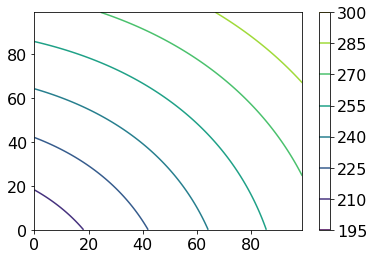

In [144]:
wavelength_m = 11.19e-6 # wavelength in meters
wavenumber_m = 1 / wavelength_m # wavenumber in m^-1

t1_ = np.linspace(200,300,100)
t2_ = np.linspace(200,300,100)

t1, t2 = np.meshgrid(t1_,t2_)

TB = pyspectral.blackbody.blackbody_wn_rad2temp(wavenumber_m, 
                                                mixed_pixel_spectral_radiance(wavenumber_m, t1, t2) )

plt.contour(TB)
plt.colorbar()

Note that the GOES ABI L1b Rad product has radiance in mW m-2 sr-1 (cm-1)-1 (toa_outgoing_radiance_per_unit_wavenumber), but the pyspectral functions want to use SI units like W m-2 sr-1 (m-1)-1

In [119]:
wavelength_m = 11.19e-6 # wavelength in meters
wavenumber_cm = 0.01 / wavelength_m # wavenumber in cm^-1
wavenumber_m = 1 / wavelength_m # wavenumber in m^-1

rad_si_units = g17_c14.rad[0] * 1e-5
tb_k = g17_c14.tb[0]+273.15

print( "rad: ", g17_c14.rad[0], " mW m-2 sr-1 (cm-1)-1" )
print( "rad: ", rad_si_units, "W m-2 sr-1 (m-1)-1" ) 
print( "tb: ", tb_k, " K \n")

tb_ = pyspectral.blackbody.blackbody_wn_rad2temp(wavenumber_m, rad_si_units )

rad_ = pyspectral.blackbody.planck(wavenumber_m, tb_k , wavelength=False)

print( tb_, "K") 

print( rad_, "W m-2 sr-1 (m-1)-1" )


rad:  60.591988  mW m-2 sr-1 (cm-1)-1
rad:  0.0006059198760986329 W m-2 sr-1 (m-1)-1
tb:  259.67427931187837  K 

259.70941337353327 K
0.0006055112486429686 W m-2 sr-1 (m-1)-1


In [47]:
g17_c14.rad[0]

60.591988

Zoomed in with more GOES bands

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  from ipykernel import kernelapp as app
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in

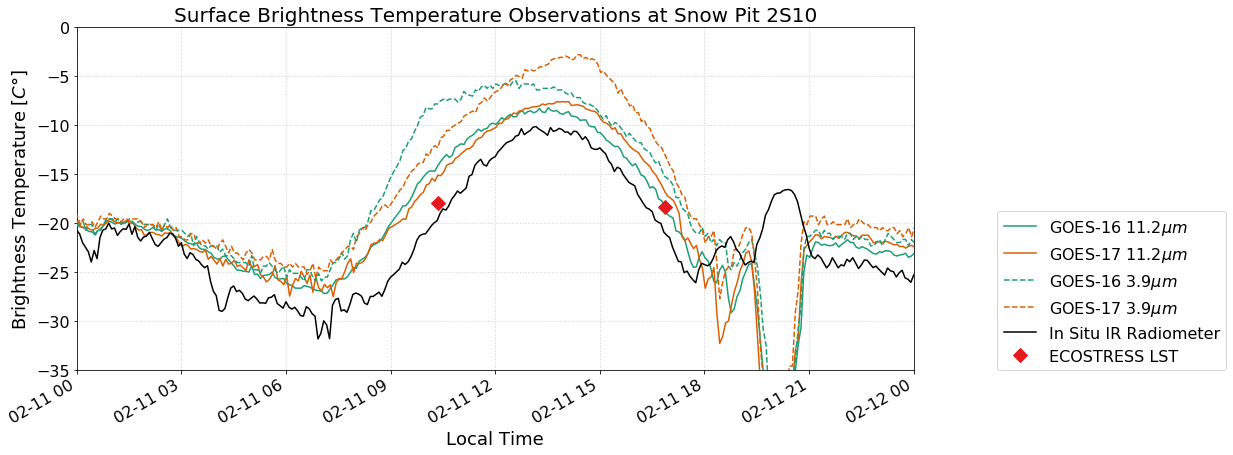

In [163]:
fig, ax = plt.subplots(1,1,figsize=(15,7))

startdate = pd.datetime(2020,2,11)
enddate = pd.datetime(2020,2,12)

g16_c14.tb.plot(ax=ax, linestyle='-', marker='', markersize=5, c='#1b9e77', label='GOES-16 11.2$\mu m$', zorder=99)
g17_c14.tb.plot(ax=ax, linestyle='-', marker='', markersize=5, c='#d95f02', label='GOES-17 11.2$\mu m$', zorder=99)

g16_c7.tb.plot(ax=ax, linestyle='--', marker='', markersize=5, c='#1b9e77', label='GOES-16 3.9$\mu m$', zorder=99)
g17_c7.tb.plot(ax=ax, linestyle='--', marker='', markersize=5, c='#d95f02', label='GOES-17 3.9$\mu m$', zorder=99)

gm1.rad_avg.plot(ax=ax, linestyle='-', marker='', markersize=0, c='k', label='In Situ IR Radiometer', zorder=99)

# ECOSTRESS Mean LST at Snow Pit 2S10 = -17.9, -18.4 C
ax.plot(pd.datetime(2020,2,11,10,22),-17.9,'D',c=eco_color,markersize=10, zorder=99, label='ECOSTRESS LST')
ax.plot(pd.datetime(2020,2,11,16,52),-18.4,'D',c=eco_color,markersize=10, zorder=99)

ax.set_ylim((-35,0))
ax.set_xlim((startdate,enddate))

ax.legend(loc=(1.1,0))
ax.set_ylabel('Brightness Temperature [$C\degree$]')
ax.set_xlabel('Local Time')
ax.set_title('Surface Brightness Temperature Observations at Snow Pit 2S10');
ax.grid(color='lightgrey', linestyle=':', linewidth=1)

Another plot zoomed in

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.


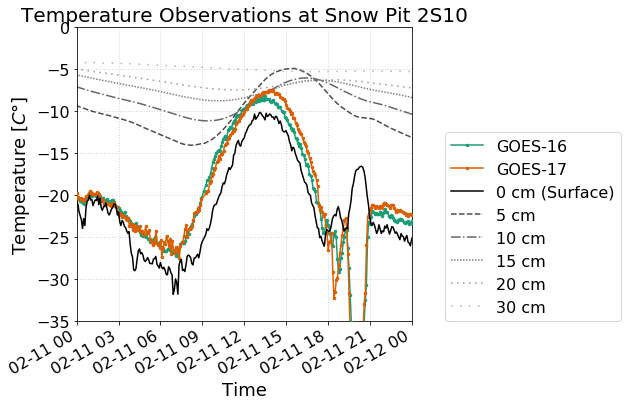

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

startdate = pd.datetime(2020,2,11)
enddate = pd.datetime(2020,2,12)

g16.tb.plot(ax=ax, linestyle='-', marker='.', markersize=5, c='#1b9e77', label='GOES-16', zorder=99)
g17.tb.plot(ax=ax, linestyle='-', marker='.', markersize=5, c='#d95f02', label='GOES-17', zorder=99)

gm1.rad_avg.plot(ax=ax, linestyle='-', marker='.', markersize=0, c='k', label='0 cm (Surface)', zorder=99)

gm1.temp1_avg.plot(ax=ax, linestyle='--', marker='.', markersize=0, c=[0.3,0.3,0.3], label='5 cm')
gm1.temp2_avg.plot(ax=ax, linestyle='-.', marker='.', markersize=0, c=[0.4,0.4,0.4], label='10 cm')
gm1.temp3_avg.plot(ax=ax, linestyle=(0, (1,1)), marker='.', markersize=0, c=[0.5,0.5,0.5], label='15 cm')
gm1.temp4_avg.plot(ax=ax, linestyle=(0, (1,3)), marker='.', markersize=0, c=[0.6,0.6,0.6], label='20 cm')
gm1.temp5_avg.plot(ax=ax, linestyle=(0, (1,5)), marker='.', markersize=0, c=[0.7,0.7,0.7], label='30 cm')


ax.set_ylim((-35,0))
ax.set_xlim((startdate,enddate))

ax.legend(loc=(1.1,0))
ax.set_ylabel('Temperature [$C\degree$]')
ax.set_xlabel('Time')
ax.set_title('Temperature Observations at Snow Pit 2S10');
ax.grid(color='lightgrey', linestyle=':', linewidth=1)